# Written text as operational data

Written text is one type of data

### Why people write?

 - To communicate: their thoughts, feelings, urgency, needs, information

### Why people communicate?

1. To express emotions
1. To share information
1. To enable or elicit an action
1. ...

### We will use written text for the purpose other than 
1. To experience emotion
1. To learn something the author intended us to learn
1. To do what the author intended us to do

### Instead, we will use written text to recognize who wrote it
 - By calculating and comparing word frequencies in written documents
 
See, for example, likely fictional story https://medium.com/@amuse/how-the-nsa-caught-satoshi-nakamoto-868affcef595

### Example 1. Dictionaries in python (associative arrays)

Plot the frequency distribution of words on a web page.

In [1]:
import requests, re
# re is a module for regular expressions: to detect various combinations of characters
import operator

# Start from a simple document
r = requests .get('http://eecs.utk.edu')

# What comes back includes headers and other HTTP stuff, get just the body of the response
t = r.text

# obtain words by splitting a string using as separator one or more (+) space/like characters (\s) 
wds = re.split('\s+',t)

# now populate a dictionary (wf)
wf = {}
for w in wds:
    if w in wf: wf [w] = wf [w] + 1
    else:  wf[w] = 1

# dictionaries can not be sorted, so lets get a sorted *list*        
wfs = sorted (wf .items(), key = operator .itemgetter (1), reverse=True)   

# lets just have no more than 15 words 
ml = min(len(wfs),15)
for i in range(1,ml,1):
    print (wfs[i][0]+"\t"+str(wfs[i][1]))  

<!DOCTYPE	1
PUBLIC	1
"-//IETF//DTD	1
2.0//EN">	1
<html><head>	1
<title>403	1
Forbidden</title>	1
</head><body>	1
<h1>Forbidden</h1>	1
<p>You	1
don't	1
have	1
permission	1
to	1


### Example 2

Lots of markup in the output, lets remove it --- 

use BeautifulSoup and nltk modules and practice some regular expressions.

In [14]:
import requests, re, nltk
from bs4 import BeautifulSoup
from nltk import clean_html
from collections import Counter
import operator

# we may not care about the usage of stop words
stop_words = nltk.corpus.stopwords.words('english') + [
 'ut', '\'re','.', ',', '--', '\'s', '?', ')', '(', ':', '\'',
 '\"', '-', '}', '{', '&', '|', u'\u2014','stop', 'the', 'to', 
 'and', 'a', 'in', 'it', 'is', 'I', 'that', 'had', 'on', 'for', 
 'were', 'was', 'project' ]

# We most likely would like to remove html markup
def cleanHtml (html):
    from bs4 import BeautifulSoup
    soup = BeautifulSoup(html, 'html.parser')
    return soup .get_text()

# We also want to remove special characters, quotes, etc. from each word
def cleanWord (w):
    # r in r'[.,"\']' tells to treat \ as a regular character 
    # but we need to escape ' with \'
    # any character between the brackets [] is to be removed 
    wn = re.sub('[,"\.\'&\|:@>*;/=]', "", w)
    # get rid of numbers
    return re.sub('^[0-9\.]*$', "", wn)
       
# define a function to get text/clean/calculate frequency
def get_wf (URL):
    # first get the web page
    r = requests .get(URL)
    
    # Now clean
    # remove html markup
    t = cleanHtml (r .text) .lower()
    
    # split string into an array of words using any sequence of spaces "\s+" 
    wds = re .split('\s+',t)
    
    # remove periods, commas, etc stuck to the edges of words
    for i in range(len(wds)):
        wds [i] = cleanWord (wds [i])
    
    # If satisfied with results, lets go to the next step: calculate frequencies
    # We can write a loop to create a dictionary, but 
    # there is a special function for everything in python
    # in particular for counting frequencies (like function table() in R)
    wf = Counter (wds)
    
    # Remove stop words from the dictionary wf
    for k in stop_words:
        wf. pop(k, None)
        
    #how many regular words in the document?
    tw = 0
    for w in wf:
       tw += wf[w] 
        
    
    # Get ordered list
    wfs = sorted (wf .items(), key = operator.itemgetter(1), reverse=True)
    ml = min(len(wfs),15)

    #Reverse the list because barh plots items from the bottom
    return (wfs [ 0:ml ] [::-1], tw)
        
# Now populate two lists    
(wf_ee, tw_ee) = get_wf('http://www.gutenberg.org/ebooks/1342.txt.utf-8')
(wf_bu, tw_bu) = get_wf('http://www.gutenberg.org/ebooks/76.txt.utf-8')

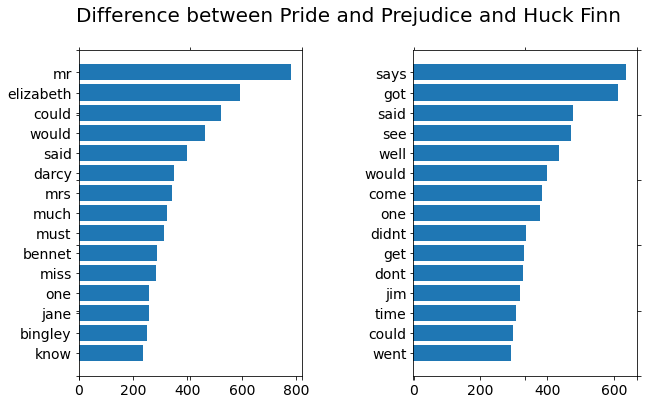

In [9]:
#Plot the results: are there striking differences in language?
import numpy as np
import pylab
import matplotlib.pyplot as plt

%matplotlib inline
def plotTwoLists (wf_ee, wf_bu, title):
    f = plt.figure (figsize=(10, 6))
    # this is painfully tedious....
    f .suptitle (title, fontsize=20)
    ax = f.add_subplot(111)
    ax .spines ['top'] .set_color ('none')
    ax .spines ['bottom'] .set_color ('none')
    ax .spines ['left'] .set_color ('none')
    ax .spines ['right'] .set_color ('none')
    ax .tick_params (labelcolor='w', top='off', bottom='off', left='off', right='off', labelsize=20)

    # Create two subplots, this is the first one
    ax1 = f .add_subplot (121)
    plt .subplots_adjust (wspace=.5)

    pos = np .arange (len(wf_ee)) 
    ax1 .tick_params (axis='both', which='major', labelsize=14)
    pylab .yticks (pos, [ x [0] for x in wf_ee ])
    ax1 .barh (range(len(wf_ee)), [ x [1] for x in wf_ee ], align='center')

    ax2 = f .add_subplot (122)
    ax2 .tick_params (axis='both', which='major', labelsize=14)
    pos = np .arange (len(wf_bu)) 
    pylab .yticks (pos, [ x [0] for x in wf_bu ])
    ax2 .barh (range (len(wf_bu)), [ x [1] for x in wf_bu ], align='center')

plotTwoLists (wf_ee, wf_bu, 'Difference between Pride and Prejudice and Huck Finn')

In [10]:
#In case Project gutenberg is blocked you can download text to your laptop and copy to the docker container via scp
#Assuming the file name you copy is pg4680.txt here is how you change the script
# Please note the option errors='replace'
# without it python invariably runs into unicode errors
f = open ('pg4680.txt', 'r', encoding="ascii", errors='replace')
    
# What comes back includes headers and other HTTP stuff, get just the body of the response
t = f.read()

# obtain words by splitting a string using as separator one or more (+) space/like characters (\s) 
wds = re.split('\s+',t)

# now populate a dictionary (wf)
wf = {}
for w in wds:
    if w in wf: wf [w] = wf [w] + 1
    else:  wf [w] = 1

# dictionaries can not be sorted, so lets get a sorted *list*        
wfs = sorted (wf .items(), key = operator .itemgetter (1), reverse=True)   

# lets just have no more than 15 words 
ml = min(len(wfs),15)
for i in range(1,ml,1):
    print (wfs[i][0]+"\t"+str(wfs[i][1]))  

and	2836
of	2676
to	2646
a	2217
in	1422
his	1205
he	928
that	920
was	823
for	798
with	797
as	672
I	505
you	497


# Assignment 1

1. Compare word frequencies between two works of a single author.
1. Compare word frequencies between works of two authors.
1. Are there some words preferred by one author but used less frequently by another author?

Extra credit

1. The frequency of a specific word, e.g., "would" should follow a binomial distribution (each regular word in a document is a trial and with probability p that word is "would". The estimate for p is N("would")/N(regular word)). Do these binomial distributions for your chosen word differ significantly between books of the same author or between authors? 

Project Gutenberg is a good source of for fiction and non-fiction.

E.g below are two most popular books from Project Gutenberg:
- Pride and Prejudice at http://www.gutenberg.org/ebooks/1342.txt.utf-8
- Adventures of Huckleberry Finn at http://www.gutenberg.org/ebooks/76.txt.utf-8

In [11]:
import requests, re, nltk
#In case your text is not on Project Gutenberg but at some other URL
#http://www.fullbooks.com/Our-World-or-The-Slaveholders-Daughter2.html
# that contains 12 parts
t = ""
for i in range(2,13):
  r = requests .get('http://www.fullbooks.com/Our-World-or-The-Slaveholders-Daughter' + str(i) + '.html')
  t = t + r.text

In [12]:
len(t)

1323653

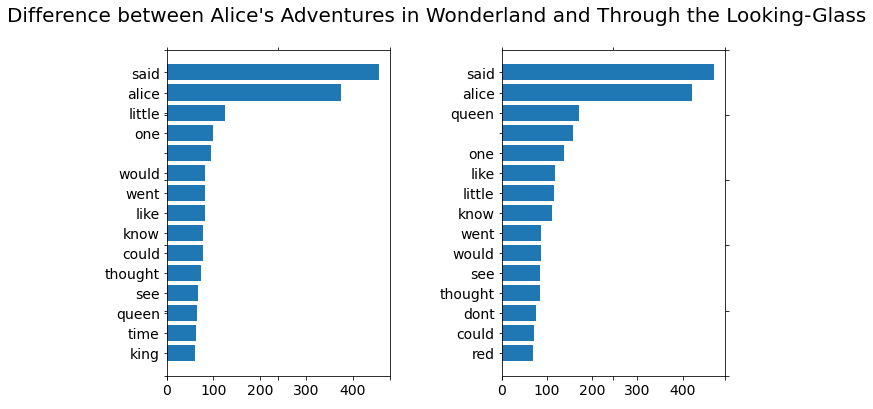

In [15]:
#1

#Comparing Alice's Adventures in Wonderland and Through the Looking-Glass by Lewis Carroll

#Obtain links of books and use previous code to compare word frequencies    
(wf_AW, tw_AW) = get_wf('http://www.gutenberg.org/ebooks/11.txt.utf-8')
(wf_HS, tw_HS) = get_wf('http://www.gutenberg.org/ebooks/12.txt.utf-8')

#plot word frequency of the two books
plotTwoLists (wf_AW, wf_HS, "Difference between Alice's Adventures in Wonderland and Through the Looking-Glass")

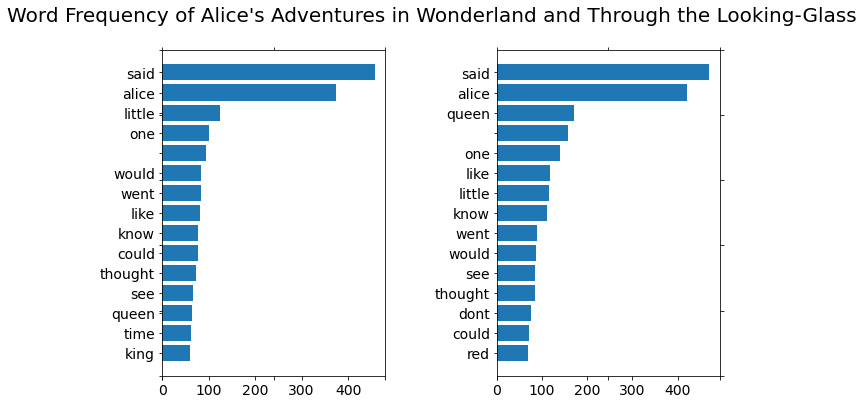

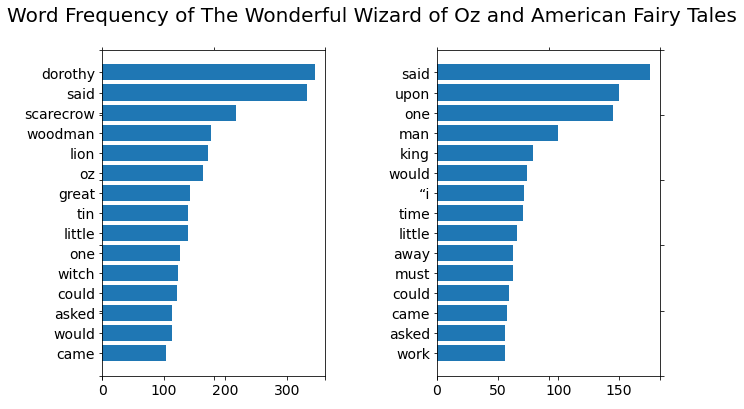

In [16]:
#2

#Comparing Alice's Adventures in Wonderland and Through the Looking-Glass by Lewis Carroll with The Wonderful Wizard of Oz
#and American Fairy Tales by L. Frank Baum

#obtain links of books and use previous code to compare word frequencies
(wf_AW, tw_AW) = get_wf('http://www.gutenberg.org/ebooks/11.txt.utf-8')
(wf_HS, tw_HS) = get_wf('http://www.gutenberg.org/ebooks/12.txt.utf-8')

(wf_OZ, tw_OZ) = get_wf('http://www.gutenberg.org/ebooks/55.txt.utf-8')
(wf_AFT, tw_AFT) = get_wf('http://www.gutenberg.org/ebooks/4357.txt.utf-8')


#plot word frequency of the two books from each author
plotTwoLists (wf_AW, wf_HS, "Word Frequency of Alice's Adventures in Wonderland and Through the Looking-Glass")
plotTwoLists (wf_OZ, wf_AFT, "Word Frequency of The Wonderful Wizard of Oz and American Fairy Tales")

#3.
Comparing the works from Lewis Caroll and L. Frank Baum, there are some words that share similarity and words that are also unique to their own writing. The two authors tend to have characters that share some higher power like Kings or Queens. L. Frank Baum's 'The Wonderful Wizard of Oz' uses mostly uses character names throughout the book since many of them are main characters in the story. Unlike Lewis Carroll's works does not contain many character names besides one main character. Then uses other terms to illustrate other characters like 'queen'.